# Introduction

In [1]:
# https://www.kaggle.com/competitions/football-match-probability-prediction

# Download the Challenge Data:
#!download -c football-match-probability-prediction 

# Setup

In [2]:
# Install Missing Packages
#!pip install pandas
#!pip install pandas-profiling
#!pip install ipywidgets
#!pip install torch
#!pip install pyspark
!pip install sklearn

In [3]:
#Load Neccessary Libraries
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import torch # Work with it!
import pyspark # Work with it!
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline 

#Load secondary libraries
import warnings
warnings.filterwarnings('ignore')


In [4]:
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv', error_bad_lines=False, index_col=False, dtype='unicode')
df_train_target_score = pd.read_csv('data/train_target_and_scores.csv')
df_sample_submission = pd.read_csv('data/sample_submission.csv')

# Exploratory Data Analysis

In [5]:
# Info about Dataframe..
#df_train.describe()
#df_train.info()
#df_train.head()
#df_train.size
print(df_train.shape)
print(df_train_target_score.shape)
print(df_test.shape)
print(df_sample_submission.shape)

(110938, 190)
(110938, 3)
(72711, 189)
(72711, 4)


In [6]:
# Grab the columns names
df_columns = df_train.columns

In [7]:
# Pandas Profile
# Profile reduced to the descriptive columns only
#profile = ProfileReport(df_train.iloc[:,0:10], title="Pandas Profiling Report", explorative=False)
#profile.to_notebook_iframe()

## Counting individual target values

home    48113
away    35174
draw    27651
Name: target, dtype: int64


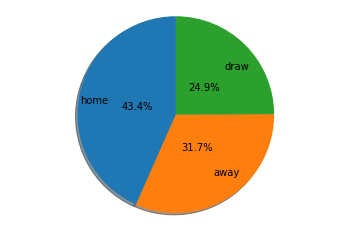

In [8]:
sizes = df_train.target.value_counts()
print(sizes)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'home', 'away', 'draw'

explode = (0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.4, labeldistance=0.7)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Feature Engineering

## Missing Values

In [22]:
#print(df_train.isna().sum())
print("Full dataframe contains "+ str(len(df_train)) + " number of lines")
df_train_woNaN = df_train.dropna()
print("NaN removed dataframe contains "+ str(len(df_train_woNaN)) + " number of lines")
print("Through removing NaNs dataframe length is only " + str(round(len(df_train_woNaN)/len(df_train)*100)) + " %")

id                                    0
target                                0
home_team_name                        1
away_team_name                        1
match_date                            0
                                  ...  
away_team_history_league_id_6      8426
away_team_history_league_id_7      9867
away_team_history_league_id_8     11295
away_team_history_league_id_9     12762
away_team_history_league_id_10    14216
Length: 190, dtype: int64

Full dataframe contains 110938 number of lines
NaN removed dataframe contains 64117 number of lines
Through removing NaNs dataframe length only 58 %


In [ ]:
#df_train.fillna(1.0, inplace=True)

In [ ]:
#df_train.isna().sum()

In [48]:
df_train_woNaN.home_team_history_goal_1.unique()
df_train_woNaN.isna().sum()

id                                      0
target                                  0
home_team_name                          0
away_team_name                          0
home_team_history_is_play_home_1        0
                                       ..
away_team_history_opponent_rating_6     0
away_team_history_opponent_rating_7     0
away_team_history_opponent_rating_8     0
away_team_history_opponent_rating_9     0
away_team_history_opponent_rating_10    0
Length: 104, dtype: int64

In [49]:
# Where possible make columns as integer
df_train_woNaN.home_team_history_goal_1 = df_train_woNaN.home_team_history_goal_1.astype('float')
df_train_woNaN.home_team_history_goal_1 = df_train_woNaN.home_team_history_goal_1.astype('int')
print(df_train_woNaN.home_team_history_goal_1.dtype)
#x = df_train.home_team_history_goal_1.value_counts().sort_index()
#plt.bar(x.index,x, tick_label=x.index)

float64
float64
int64


In [23]:
df = df_train_woNaN

In [ ]:


# home_team_history_is_cup_{i} - If 1, the match was a cup competition.
# home_team_history_goal_{i} - The number of goals scored by the Home team on its last i-th match.
# home_team_history_opponent_goal_{i} - The number of goals conceded by the Home team on its last i-th match.
# home_team_history_rating_{i} - The rating of the Home team on its last i-th match (pre match rating).
# home_team_history_opponent_rating_{i} - The rating of the opponent team on Home team last i-th match (pre match rating).
# home_team_history_coach_{i} - The coach id of the Home team on its last i-th match.
# home_team_history_league_id_{i} - The league name id by the Home team on its last i-th match.

In [100]:
# Pre Processing History Columns.. 
# home_team_history_is_play_home_{i} - If 1, the Home team played home.
# away_team_history_is_play_home_{i} - If 1, the Away team played home.

#df_train_woNaN['home_team_history_is_play_home_1'] = df_train_woNaN['home_team_history_is_play_home_1'].astype('float')
#df_train_woNaN['home_team_history_is_play_home_1'] = df_train_woNaN['home_team_history_is_play_home_1'].astype('int')
#print(df_train_woNaN['home_team_history_is_play_home_1'].dtype)

for i in range(1,11):
    df_train_woNaN['home_team_history_is_play_home_' + str(i)] = df_train_woNaN['home_team_history_is_play_home_' + str(i)].astype('float')
    df_train_woNaN['away_team_history_is_play_home_' + str(i)] = df_train_woNaN['away_team_history_is_play_home_' + str(i)].astype('float')
    df_train_woNaN['home_team_history_is_play_home_' + str(i)] = df_train_woNaN['home_team_history_is_play_home_' + str(i)].astype('int')
    df_train_woNaN['away_team_history_is_play_home_' + str(i)] = df_train_woNaN['away_team_history_is_play_home_' + str(i)].astype('int')
    print(df_train_woNaN['home_team_history_is_play_home_' + str(i)].value_counts())
    print(df_train_woNaN['away_team_history_is_play_home_' + str(i)].value_counts())
    print(df_train_woNaN['home_team_history_is_play_home_' + str(i)].dtype)
    print(df_train_woNaN['away_team_history_is_play_home_' + str(i)].dtype)

1    45812
0    18305
Name: home_team_history_is_play_home_1, dtype: int64
1    45812
0    18305
Name: away_team_history_is_play_home_1, dtype: int64
int64
int64
1    36627
0    27490
Name: home_team_history_is_play_home_2, dtype: int64
0    36401
1    27716
Name: away_team_history_is_play_home_2, dtype: int64
int64
int64
0    34634
1    29483
Name: home_team_history_is_play_home_3, dtype: int64
1    34679
0    29438
Name: away_team_history_is_play_home_3, dtype: int64
int64
int64
1    33468
0    30649
Name: home_team_history_is_play_home_4, dtype: int64
0    33304
1    30813
Name: away_team_history_is_play_home_4, dtype: int64
int64
int64
0    33091
1    31026
Name: home_team_history_is_play_home_5, dtype: int64
1    33203
0    30914
Name: away_team_history_is_play_home_5, dtype: int64
int64
int64
1    32420
0    31697
Name: home_team_history_is_play_home_6, dtype: int64
0    32473
1    31644
Name: away_team_history_is_play_home_6, dtype: int64
int64
int64
0    32443
1    31674
Name: 

In [70]:
df_train_woNaN['home_team_history_is_play_home_1']

0         0.0
1         1.0
2         0.0
3         0.0
4         0.0
         ... 
110932    1.0
110934    0.0
110935    0.0
110936    0.0
110937    0.0
Name: home_team_history_is_play_home_1, Length: 64117, dtype: object

# Pre-Processing

## Remove not required data

In [24]:
# Remove the DATE columns
for col in df_columns:
    if 'date' in col:
        df.drop(col, axis=1, inplace=True)
                
# Remove the CUP columns
for col in df_columns:
    if 'cup' in col:
        df.drop(col, axis=1, inplace=True)
        
# Remove the COACH columns
for col in df_columns:
    if 'coach' in col:
        df.drop(col, axis=1, inplace=True) 
        
# Remove the LEAGUE columns
for col in df_columns:
    if 'league' in col:
        df.drop(col, axis=1, inplace=True) 
        
print(df.shape)

(64117, 104)


In [25]:
df.iloc[0,0:10]

id                                           11906497
target                                           away
home_team_name                      Newell's Old Boys
away_team_name                            River Plate
home_team_history_is_play_home_1                  0.0
home_team_history_is_play_home_2                  1.0
home_team_history_is_play_home_3                  0.0
home_team_history_is_play_home_4                  1.0
home_team_history_is_play_home_5                  0.0
home_team_history_is_play_home_6                  1.0
Name: 0, dtype: object

## Train-Test Split

In [34]:
# Random seed set here for entire notebook
seed = 42

# Assign the data to x, y
y = df.target 
X = df.iloc[:,4:-1]

# Normalize Data
scaler = MinMaxScaler()
#X_norm = scaler.fit_transform(X)

# Split the data..
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [28]:
X_norm

array([[0.        , 1.        , 0.        , ..., 0.09908383, 0.04774285,
        0.05173912],
       [1.        , 0.        , 1.        , ..., 0.15473143, 0.12931077,
        0.16196629],
       [0.        , 1.        , 0.        , ..., 0.10101384, 0.11706773,
        0.10213484],
       ...,
       [0.        , 0.        , 1.        , ..., 0.06735747, 0.09399555,
        0.14872777],
       [0.        , 1.        , 0.        , ..., 0.14279482, 0.15800245,
        0.10029341],
       [0.        , 1.        , 0.        , ..., 0.13888676, 0.13123006,
        0.12042594]])

# Prediction

## Base Model: SVM

### Fitting

In [35]:
SVM_classifier = svm.LinearSVC(verbose=True)
SVM_classifier.fit(X_train, y_train)

[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -15294.053460
nSV = 44731
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -15159.582992
nSV = 44846
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -17563.348444
nSV = 44768


LinearSVC(verbose=True)

### Prediction

In [36]:
y_pred = SVM_classifier.predict(X_test)

### Evaluation

In [37]:
target_names = ['home', 'draw', 'away']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        home       0.44      0.42      0.43      6114
        draw       0.27      0.02      0.03      4899
        away       0.49      0.78      0.60      8223

    accuracy                           0.47     19236
   macro avg       0.40      0.40      0.35     19236
weighted avg       0.42      0.47      0.40     19236



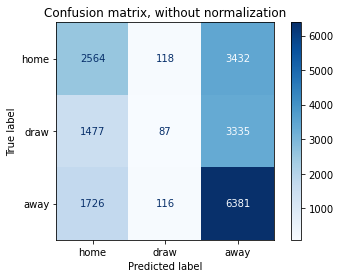

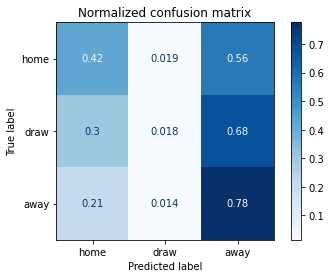

In [38]:
titles_options = [("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true")]

class_names = target_names
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        SVM_classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()

## Advanced Model: CNN

## Fitting

## Prediction

## Evaluation

# Visualisation

# Output

## Transfrom according sample submission